# Dereverb - DAAP Project

Students: 

*   Federico Maver ( ID: 10565151, MATR: 952840 )
*   Filippo Gualtieri ( ID: , MATR: 953546 )

Import libraries:

In [1]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import librosa, librosa.display
import pyroomacoustics as pra
from scipy.io import wavfile
import IPython.display as ipd
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection
import soundfile as sf

### Part 1: RIR and reverberation
From the image we can see that values of beta should be chosen between 0.2 for small rooms (4 m per side) and 1.8 for very big rooms (30 m per side);

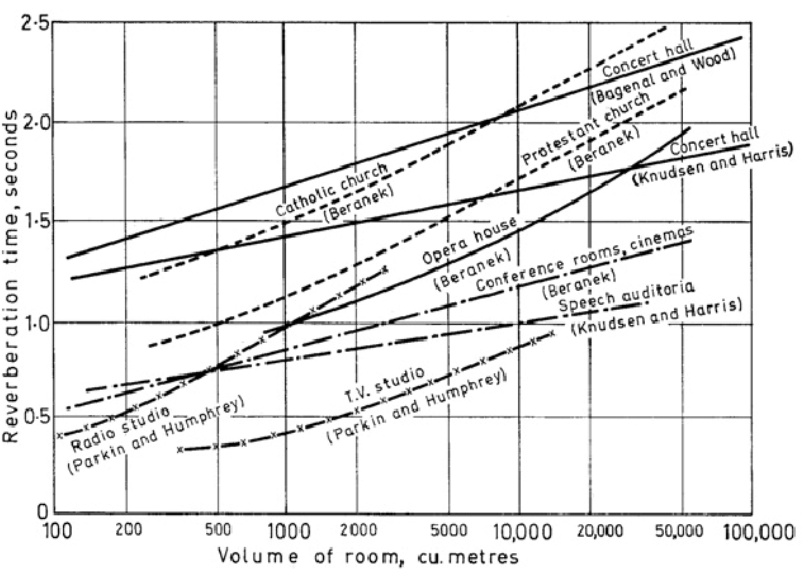

In [2]:
ipd.Image(filename = "images/RevTime1.png", width = 600, height = 300)

Let's define some parameters:

In [3]:
fs = 8000 # sampling rate (Hz)

rt60_tgt = 0.6  # reverberation time (s)
room_dim = [10, 7.5, 3.5]  # room dimensions (m)

source_pos = [5, 1, 1] # x, y, z position of the source (m)
mic_locs = np.c_[ [4.7, 5, 1.2] ] # location of the microphone / microphone array (m)

Visualization of the room with source and mics:

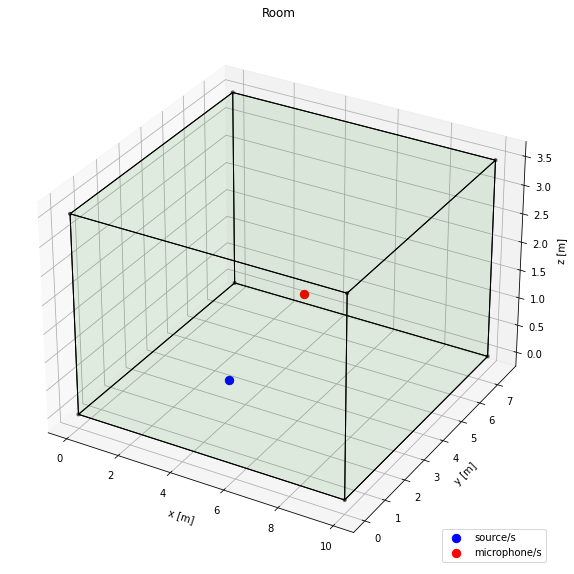

In [4]:
# vertices of the room
v = np.array([[0, 0, 0], [room_dim[0], 0, 0], [room_dim[0], room_dim[1], 0], [0, room_dim[1], 0], [0, 0, room_dim[2]], [room_dim[0], 0, room_dim[2]], [room_dim[0], room_dim[1], room_dim[2]], [0, room_dim[1], room_dim[2]]])

# room, sources and mics plot
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(source_pos[0], source_pos[1], source_pos[2], c='b', s=70)
ax.scatter(mic_locs[0, :], mic_locs[1, :], mic_locs[2, :], c='r', s=70)

ax.scatter3D(v[:, 0], v[:, 1], v[:, 2], s=10, c='k', alpha=0.5)

# generate list of sides' polygons of our room
walls = [ [v[0],v[1],v[2],v[3]], [v[4],v[5],v[6],v[7]], [v[2],v[3],v[7],v[6]], [v[0],v[3],v[7],v[4]], [v[0],v[1],v[5],v[4]], [v[1],v[2],v[6],v[5]] ]

# plot sides
ax.add_collection3d(Poly3DCollection(walls, facecolors='green', linewidths=1, edgecolors='k', alpha=0.05))

ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')
ax.set_zlabel('z [m]')
ax.set_title('Room')
ax.legend(('source/s','microphone/s'), loc='lower right', frameon=True);

Now generate the RIR and apply it to the audio files

In [5]:
# import a mono wavfile as the source signal
# the sampling frequency should match that of the room
audio, fs = librosa.load('audio/simple_piano.wav', sr=fs)
audio = audio[:fs*2]

In [6]:
# We invert Sabine's formula to obtain the parameters for the ISM simulator
e_absorption, max_order = pra.inverse_sabine(rt60_tgt, room_dim)

# Create the room
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order);

# volume of the room
print("The volume of the room is {} m\u00b3".format(room.get_volume()))

The volume of the room is 262.5 m³


In [7]:
# place the source in the room
room.add_source(source_pos, signal=audio, delay=0.1); #delay=0.5

# place the microphone array in the room
room.add_microphone_array(mic_locs);

In [8]:
# Run the simulation (this will also build the RIR automatically)
room.simulate()

# Save the reverberated audio into a file
room.mic_array.to_wav(
    f"audio/generated/voiced_aREV.wav",
    norm=True,
    bitdepth=np.int16,
)

global_delay = pra.constants.get("frac_delay_length") // 2

print('Global delay introduced by the simulation:', global_delay)

# measure the reverberation time
rt60 = room.measure_rt60()
print("The desired RT60 was {} s".format(rt60_tgt))
print("The measured RT60 is {} s".format(rt60[0, 0]))

Global delay introduced by the simulation: 40
The desired RT60 was 0.6 s
The measured RT60 is 0.975875 s


Original signal: (16000,)
RIR: (1, 1, 15016)
Reverberated signal: (31816,)


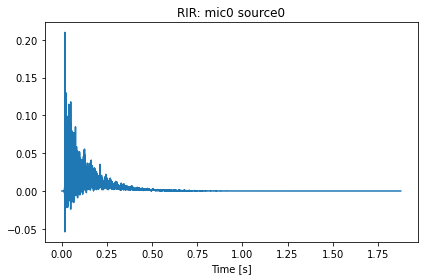

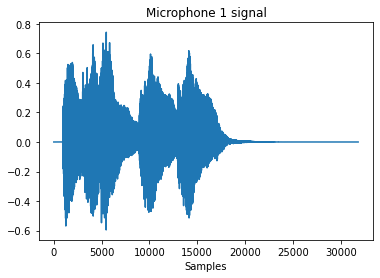

In [9]:
# Plot the RIRs
room.plot_rir()

plt.figure()
# plot signal at microphone 1
plt.plot(room.mic_array.signals[0, :])
plt.title("Microphone 1 signal")
plt.xlabel("Samples");


print('Original signal:', audio.shape)
print('RIR:', np.array(room.rir).shape )
print('Reverberated signal:', np.array(room.mic_array.signals[0, :]).shape)

In [10]:
sf.write('audio/RIR.wav', np.array(np.squeeze(room.rir)), samplerate=fs)

#### Audio files
Dry signal:

In [11]:
ipd.display(ipd.Audio(audio, rate=fs)) 

Reverberated signal:

In [12]:
ipd.display(ipd.Audio(room.mic_array.signals[0, :], rate=fs))

In [21]:
# select a large number so that signals are all the same length:
sig_length = len(room.mic_array.signals[0, :])
N_samples = int(pow(2, np.ceil(np.log(sig_length)/np.log(2))))

print(sig_length)
print('Next power of 2:', N_samples)

31816
Next power of 2: 32768


In [23]:
# step 1
#h = np.squeeze(np.asarray(room.rir))
h = np.squeeze(np.array(room.rir))
H = np.fft.fft(h, n=N_samples)

print('RIR shape:', h.shape)
print('RIR DFT shape:', H.shape)


RIR shape: (15016,)
RIR DFT shape: (32768,)


In [ ]:
# is DFT correct? yes. prove...
# freqaxis=np.fft.fftfreq(len(h[0,:]))
# print(np.squeeze(H).shape)
# mag = np.abs(np.squeeze(H))**2
# print(mag.shape)
# phase = np.angle(np.squeeze(H))
# print(mag.shape)
# print(freqaxis.shape)

# plt.figure(figsize=(5,10))
# plt.subplot(2,1,1)
# plt.plot(mag)
# plt.subplot(2,1,2)
# plt.plot(freqaxis,phase[0,:])

# inversecheck=np.fft.ifft(H_f[0,:])
# plt.figure(figsize=(5,10))
# plt.plot(inversecheck)

# ipd.display(ipd.Audio(inversecheck, rate=fs))
# ipd.display(ipd.Audio(room.rir[1][0], rate=fs))

In [15]:
#compute the log of the frequency response
H_hat=np.log(np.abs(H))+ 1j*np.angle(H)
#compute the even part of the cepstrum
n=np.arange(0,len(H[0,:]),1)
k=n
print(k.shape,n)
#SOMMATORIA PROBLEMATICA, NP.SUM(NP.FROMITER(FUNZIONE PER N IN N, TIPO FINALE))
#he=(1/len(H_f[0]))*np.sum(np.fromiter([(1/len(H_f[0])*np.log(np.abs(H_f))*np.exp((1j)*2*np.pi*k*n)) for n in n], H_f.dtype))

#print(he.shape)

(1,) [0]


32768


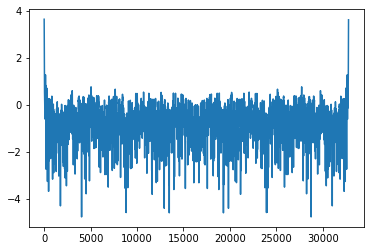

In [25]:
# step 2
# H_hat
H_amp_log = np.log(np.abs(H))
H_phase = np.angle(H)
H_hat = H_amp_log + H_phase

N = H.shape[-1]
k = np.arange(0,N)
print(N)
plt.plot(H_amp_log);

In [17]:
# step 3
# INFERNALE (1 minuto e mezzo a 8kHz, 5 minuti a 16kHz)
# TODO: sistema per più microfoni
h_e_hat = np.zeros((1,N), dtype=np.complex)
# s = np.zeros((N,N), dtype=np.complex)
for i in tqdm(range(N)):
    s[i,:] = H_amp_log[i]*np.exp(1j*(2*np.pi/N)*k*i)
    h_e_hat[k] = 


100%|██████████| 40000/40000 [02:22<00:00, 280.41it/s]


In [18]:
# INFERNALE
h_e_hat = (1/N)*np.sum(s,axis=0) # sum all the elements in a column
print('Size of matrix:', s.shape)
print('Size of even part of complex cepstrum:', h_e_hat.shape)

Size of matrix: (40000, 40000)
Size of even part of complex cepstrum: (40000,)


In [22]:
reset s

Don't know how to reset  s, please run `%reset?` for details


In [23]:
# step 4
h_mp_hat = np.zeros(N, dtype=np.complex)

h_mp_hat[1:int(N/2)] = h_e_hat[1:int(N/2)]
h_mp_hat[0] =  h_e_hat[0]
h_mp_hat[int(N/2)] =  h_e_hat[int(N/2)]

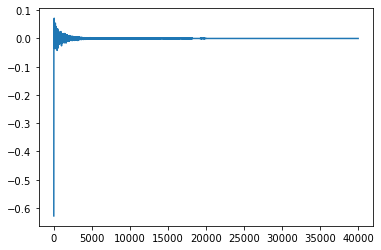

In [24]:
plt.plot(h_mp_hat)

In [25]:
# step 5
# INFERNALE
s1 = np.zeros((N,N), dtype=np.complex)

for i in tqdm(range(N)):
    s1[i,:] = h_mp_hat[i]*np.exp(-1j*(2*np.pi/N)*k*i)

100%|██████████| 40000/40000 [01:59<00:00, 336.09it/s]


In [26]:
# !!! qualche errore qua, esce piatto!
print(s1)

[[-0.62838389+0.00000000e+00j -0.62838389+0.00000000e+00j
  -0.62838389+0.00000000e+00j ... -0.62838389+0.00000000e+00j
  -0.62838389+0.00000000e+00j -0.62838389+0.00000000e+00j]
 [ 0.00282675-4.11275452e-17j  0.00282675-4.44024715e-07j
   0.00282675-8.88049419e-07j ...  0.00282675+1.33207410e-06j
   0.00282675+8.88049419e-07j  0.00282675+4.44024715e-07j]
 [-0.01603075-4.29932457e-17j -0.01603074+5.03620705e-06j
  -0.01603074+1.00724136e-05j ... -0.01603074-1.51086192e-05j
  -0.01603074-1.00724136e-05j -0.01603074-5.03620705e-06j]
 ...
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.        +0.00000000e+00j
   0.        +0.00000000e+00j  0.        +0.00000000e+00j]
 [ 0.        +0.00000000e+00j  0.        +0.00000000e+00j
   0.        +0.00000000e+00j ...  0.     

In [27]:
# INFERNALE
H_mp_hat = np.sum(s1,axis=0) # sum all the elements in a column
print(H_mp_hat)

[1.50528191+1.07571592e-12j 1.49305713-1.28163279e-01j
 1.45877192-2.47338870e-01j ... 1.40944431+3.52319974e-01j
 1.45877192+2.47338870e-01j 1.49305713+1.28163279e-01j]


In [33]:
reset s1

Don't know how to reset  s1, please run `%reset?` for details


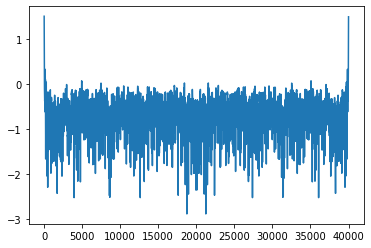

In [34]:
plt.plot(H_mp_hat)

(40000,)
(0.5063953255381031+0.32816538113503047j)


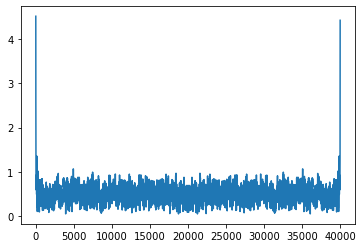

In [35]:
# step 6
H_mp = np.exp(H_mp_hat)
print(H_mp.shape)
print(H_mp[2460])
plt.plot(H_mp)

In [36]:
G_mp = 1/H_mp
print(G_mp.shape)

(40000,)


In [37]:
H_ap = H*G_mp
print(H_ap.shape)

(40000,)


Apply to signal and see the result:

In [47]:
# wet spectrum:
X = np.fft.fft(room.mic_array.signals[0, 0:N], n=N)
print(X.shape)

(40000,)


In [57]:
# dereverberated:
X_der = X * H_mp * H_ap
print(X_der.shape)
print(X_der)

(40000,)
[30823.88893506-6.61744490e-24j -9453.01130078-1.68843655e+04j
 -2179.89136336-4.02321534e+02j ... -5257.77982653-1.64515449e+03j
 -2179.89136336+4.02321534e+02j -9453.01130078+1.68843655e+04j]


In [58]:
x_der = np.fft.ifft(X_der)
x_der = np.abs(x_der)
print(x_der.shape)

(40000,)


In [59]:
ipd.display(ipd.Audio(x_der, rate=fs))

In [60]:
sf.write('audio/try.wav', x_der, samplerate=fs)